In [1]:
import os

import cv2
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb

In [2]:
!nvidia-smi

Wed Mar  8 13:21:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.64       Driver Version: 512.64       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8     9W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
# wandb.init(project="my-awesome-project")

In [5]:
DATA_DIR = './Images/'
MASK_DIR = './Masks/'

In [6]:
def visualize(rows=1, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(rows, n//rows, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def image_to_same_shape(image, height, width):
    if len(image.shape) == 2:
      old_image_height, old_image_width = image.shape
    else:
      old_image_height, old_image_width, channels = image.shape

    # create new image of desired size and color (blue) for padding
    new_image_width = width
    new_image_height = height
    color = (0)
    if len(image.shape) == 2:
      result = np.full((new_image_height,new_image_width), color, dtype=np.uint8)
    else:
      result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image
    result[y_center:y_center+old_image_height, 
          x_center:x_center+old_image_width] = image
    
    return result


In [7]:
class Dataset:
    """Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'seed', 'pulp', 'albedo', 'flavedo']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [image_id.replace(".png", "") for image_id in os.listdir(masks_dir)]
        # self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        # print(self.images_fps[0])
        self.masks_fps = [os.path.join(masks_dir, image_id)+'.png' for image_id in self.ids]
        # print(self.masks_fps[0])
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        image = image_to_same_shape(image, 1024, 1024)
        mask = image_to_same_shape(mask, 1024, 1024)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v*(255//4)) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    

In [8]:
class_labels = {0: "Seed",
                1: "Pulp",
                2: "Albedo",
                3: "Flavedo",
                4: "Background"
               }

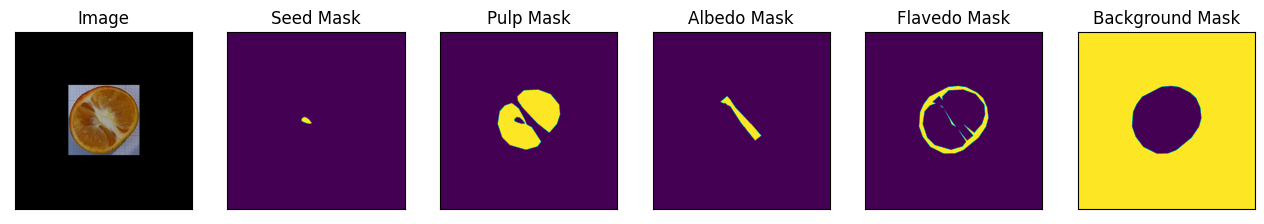

In [9]:
dataset = Dataset(DATA_DIR, MASK_DIR, classes=['seed', 'pulp', 'albedo', 'flavedo'])

dataset_image, mask = dataset[5] # get some sample
visualize(
    image=dataset_image, 
    seed_mask=mask[..., 0].squeeze(),
    pulp_mask=mask[..., 1].squeeze(),
    albedo_mask=mask[..., 2].squeeze(),
    flavedo_mask=mask[..., 3].squeeze(),
    background_mask=mask[..., 4].squeeze(),
)

In [10]:
image = wandb.Image(dataset_image, caption="Input image")
wandb.log({"example_image": image})

Error: You must call wandb.init() before wandb.log()

In [ ]:
image = wandb.Image(dataset_image, 
                    masks={"ground_truth": {
                            "mask_data": np.argmax(mask, axis=-1).squeeze(),
                            "class_labels": class_labels
                    }}
                    , caption="Masks")
wandb.log({"example_image": image})

In [ ]:
# image = wandb.Image(dataset_image, caption="Input image")
# wandb.log({"progress_image": image})

In [13]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [14]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [15]:
import albumentations as A

In [16]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [17]:
BACKBONE = 'efficientnetb0'
BATCH_SIZE = 1
CLASSES = ['seed', 'pulp', 'albedo', 'flavedo']
LR = 0.0001
EPOCHS = 4

preprocess_input = sm.get_preprocessing(BACKBONE)

In [18]:
wandb.config.update({"epochs": EPOCHS, "lr": LR, "backbone": BACKBONE, "architecture": "Linknet", "activation": "softmax"})

In [19]:
# define network parameters
n_classes = len(CLASSES) + 1
activation = 'softmax'

#create model
model = sm.Linknet(BACKBONE, classes=n_classes, activation=activation)

In [20]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [21]:
from wandb.keras import WandbEvalCallback, WandbMetricsLogger

In [22]:
class PlotSampleImages(keras.callbacks.Callback):
    def __init__(self):
        super(PlotSampleImages, self).__init__()
    def on_epoch_end(self, epoch, logs=None):
        train_pred = self.model.predict(np.expand_dims(dataset_image, axis=0))
        
        image = wandb.Image(dataset_image, 
                    masks={"predicted_mask": {
                            "mask_data": np.argmax(train_pred, axis=-1).squeeze(),
                            "class_labels": class_labels
                    }}
                    , caption="Masks")
        wandb.log({"progress_image": image})

In [23]:
# Dataset for train images
train_dataset = Dataset(
    DATA_DIR, 
    MASK_DIR, 
    classes=CLASSES, 
)

# Dataset for validation images
valid_dataset = Dataset(
    DATA_DIR, 
    MASK_DIR,
    classes=CLASSES, 
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    wandb.keras.WandbModelCheckpoint('./keras_checkpoints/best_model_{epoch:02d}', save_weights_only=True, save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(),
    wandb.keras.WandbMetricsLogger(),
    PlotSampleImages()
]

In [24]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/4
23/23 [==============================] - 45s 1s/step - loss: 0.9102 - iou_score: 0.0377 - f1-score: 0.0690 - val_loss: 1.0110 - val_iou_score: 0.0705 - val_f1-score: 0.1065 - lr: 1.0000e-04
Epoch 2/4
23/23 [==============================] - 38s 2s/step - loss: 0.8680 - iou_score: 0.0961 - f1-score: 0.1525 - val_loss: 0.9103 - val_iou_score: 0.1441 - val_f1-score: 0.1872 - lr: 1.0000e-04
Epoch 3/4
23/23 [==============================] - 37s 2s/step - loss: 0.8222 - iou_score: 0.1848 - f1-score: 0.2513 - val_loss: 0.8579 - val_iou_score: 0.1883 - val_f1-score: 0.2404 - lr: 1.0000e-04
Epoch 4/4
23/23 [==============================] - 37s 2s/step - loss: 0.7799 - iou_score: 0.2450 - f1-score: 0.3079 - val_loss: 0.8312 - val_iou_score: 0.2400 - val_f1-score: 0.3000 - lr: 1.0000e-04


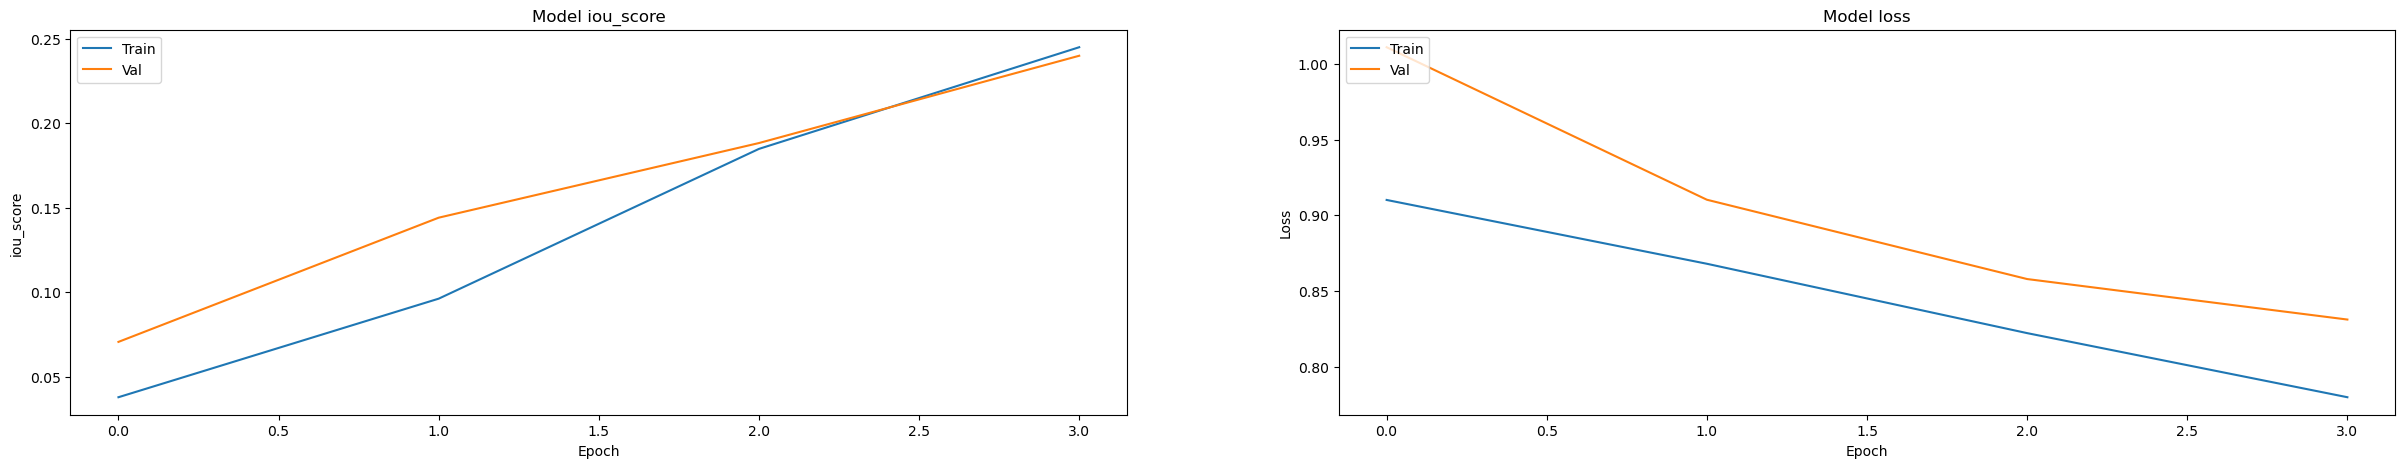

In [25]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [26]:
test_dataset = Dataset(
    DATA_DIR, 
    MASK_DIR, 
    classes=CLASSES, 
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
# load best weights
# model.load_weights('best_model.h5') 
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

23/23 [==============================] - 6s 252ms/step - loss: 0.8312 - iou_score: 0.2400 - f1-score: 0.3000
Loss: 0.83118
mean iou_score: 0.23995
mean f1-score: 0.30002


In [27]:
image = wandb.Image(dataset_image, 
                    masks={"predicted_mask": {
                            "mask_data": np.argmax(model.predict(np.expand_dims(dataset_image, axis=0)), axis=-1).squeeze(),
                            "class_labels": class_labels
                    }}
                    , caption="Masks Predicted")
wandb.log({"example_image": image})

1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 183ms/step


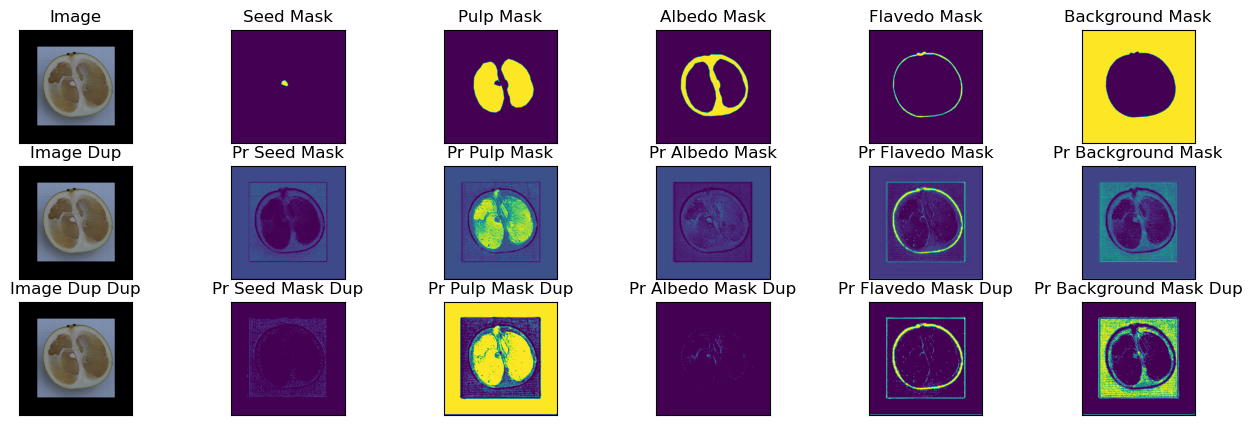

1/1 [==============================] - 0s 80ms/step


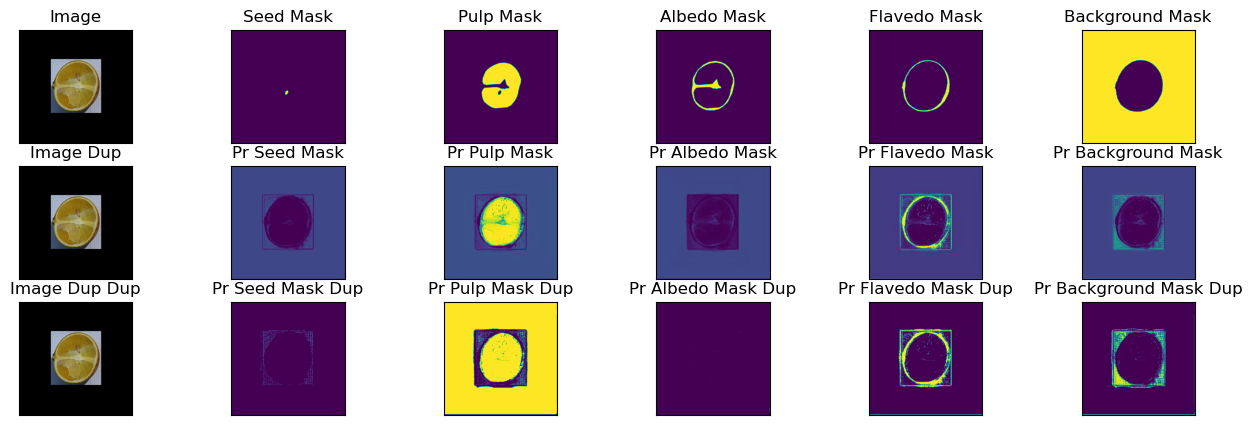

1/1 [==============================] - 0s 88ms/step


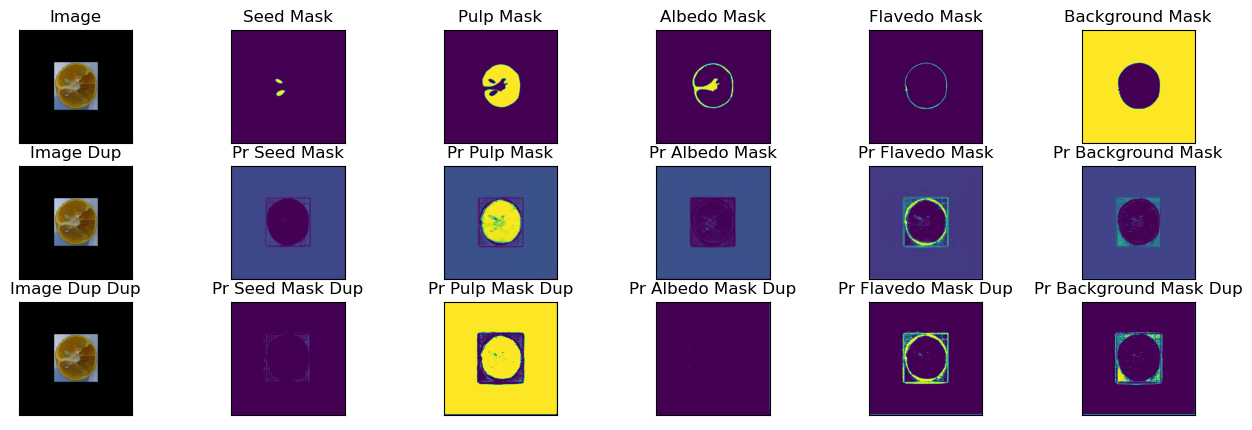

1/1 [==============================] - 0s 78ms/step


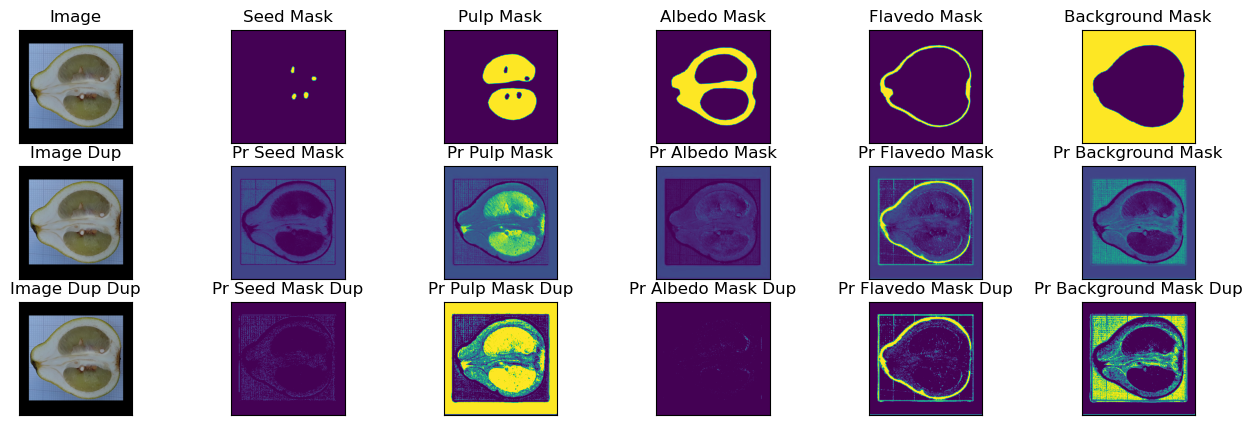

1/1 [==============================] - 0s 92ms/step


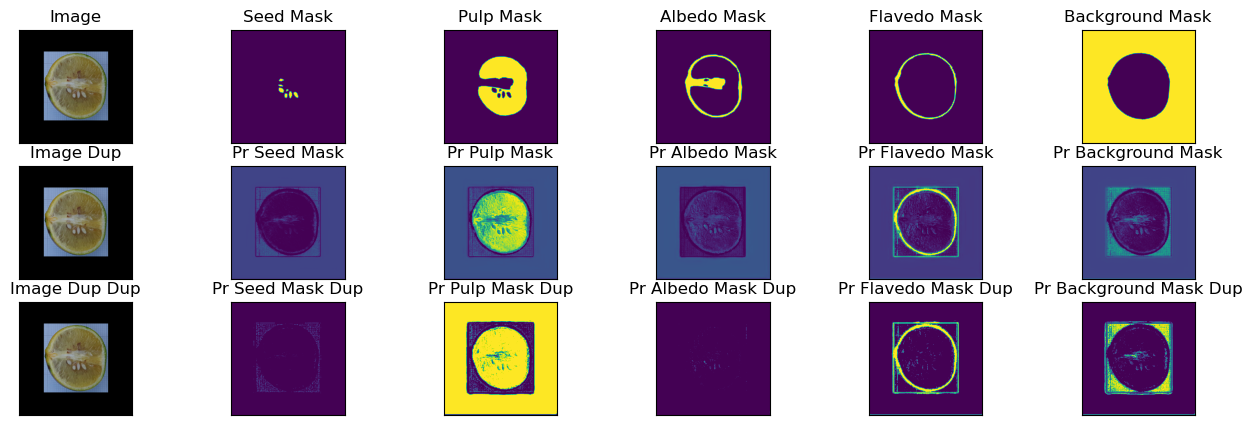

In [28]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    max_channel_mask = np.argmax(pr_mask, axis=-1)
    sharper_seed_mask = np.zeros_like(max_channel_mask)
    sharper_pulp_mask = np.zeros_like(max_channel_mask)
    sharper_albedo_mask = np.zeros_like(max_channel_mask)
    sharper_flavedo_mask = np.zeros_like(max_channel_mask)
    sharper_background_mask = np.zeros_like(max_channel_mask)
    sharper_seed_mask[max_channel_mask == 0] = 1
    sharper_pulp_mask[max_channel_mask == 1] = 1
    sharper_albedo_mask[max_channel_mask == 2] = 1
    sharper_flavedo_mask[max_channel_mask == 3] = 1
    sharper_background_mask[max_channel_mask == 4] = 1

    visualize(
        3,
        image=image.squeeze(),
        seed_mask=gt_mask[..., 0].squeeze(),
        pulp_mask=gt_mask[..., 1].squeeze(),
        albedo_mask=gt_mask[..., 2].squeeze(),
        flavedo_mask=gt_mask[..., 3].squeeze(),
        background_mask=gt_mask[..., 4].squeeze(),
        image_dup=image.squeeze(),
        pr_seed_mask=pr_mask[..., 0].squeeze(),
        pr_pulp_mask=pr_mask[..., 1].squeeze(),
        pr_albedo_mask=pr_mask[..., 2].squeeze(),
        pr_flavedo_mask=pr_mask[..., 3].squeeze(),
        pr_background_mask=pr_mask[..., 4].squeeze(),
        image_dup_dup=image.squeeze(),
        pr_seed_mask_dup=sharper_seed_mask.squeeze(),
        pr_pulp_mask_dup=sharper_pulp_mask.squeeze(),
        pr_albedo_mask_dup=sharper_albedo_mask.squeeze(),
        pr_flavedo_mask_dup=sharper_flavedo_mask.squeeze(),
        pr_background_mask_dup=sharper_background_mask.squeeze(),
    )

In [29]:
wandb.finish()

epoch/epoch,▁▃▆█
epoch/f1-score,▁▃▆█
epoch/iou_score,▁▃▆█
epoch/learning_rate,▁▁▁▁
epoch/loss,█▆▃▁
epoch/lr,▁▁▁▁
epoch/val_f1-score,▁▄▆█
epoch/val_iou_score,▁▄▆█
epoch/val_loss,█▄▂▁
epoch/epoch,3
epoch/f1-score,0.30793
